# An event-based, semi-analytic implementation of correlation-based aggregate-label learning

Summary:

1) Generate input patterns

2) Obtain the output spike times, validated on numerics from time discretization

3) Compute the correlation-based eligibilities, validated on numerics from time discretization, and update weights

--Max Puelma Touzel 24/08/2018

In [1]:
#pkgs/utilities
import numpy as np
import pandas as pd
from functools import partial
from copy import deepcopy
import time

#graphics/appearance (turn on code folding!)
%matplotlib inline
import pylab as pl
import matplotlib as mpl
mpl.rc("figure", facecolor="gray") #for dark themes
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import tempytron_lib
reload(tempytron_lib)
from tempytron_lib import *

## 1. Generating blocks of the input stream

An finite block of input stream is generated from a duration of random activity by inserting features at randomly sampled occurence times. The number of occurences for each feature is also sampled randomly.

In [2]:
#example set of input ensemble parameters
#input parsing
# fea_labels=np.arange(1,5+1) #0:distractor,>0:clue, non-distinct labels group features into a single clue.
fea_labels=np.array([1.,0.,0.,0.,0.,0.,0.,0.,0.,0.],dtype=float) #0:distractor,>0:clue, non-distinct labels group features into a single clue.
# fea_labels=np.array([1.],dtype=float) #0:distractor,>0:clue, non-distinct labels group features into a single clue.

num_fea=len(fea_labels)
# fea_count_means=np.arange(1,5)
fea_count_means=5.*np.ones(num_fea)  #homogeneous across features ints better?
num_syn=500
seed=10
np.random.seed(seed)
ens_para_dict={'feature_duration':50.,'avg_syn_firingrate':5*1/1000.}
fea_patterns=[gen_spk_data(num_syn, ens_para_dict['avg_syn_firingrate'], ens_para_dict['feature_duration']) for fea in range(num_fea)]#list of dataframes
feature_data={'data':fea_patterns,'ensemble_paras':ens_para_dict}

realize a single input block:

In [3]:
pattern_df,occur_df=get_input_pattern(feature_data,fea_count_means,num_syn,seed=seed)

In [4]:
def add_markers(occur_df,ax,num_syn=0):
    y_max=1 if num_syn==0 else num_syn
    markers = []
    color = ['r','b','g','m', '#FF6600', '#00ffff', '#FDEE00', '#D71868', 'y', 'c', 'k']
    for occurence in occur_df.itertuples():
        ax.add_patch(mpl.patches.Rectangle((occurence.occur_times, 1.1*y_max), ens_para_dict['feature_duration'], 0.1*y_max, fc = color[occurence.occur_idx], ec = '#000000'))

,occur_idx,occur_times
0,4,23.540829
1,5,82.797229
2,8,132.797488
3,7,199.104613
4,6,256.357246
5,2,308.075944
6,2,366.743097
7,5,435.561490
8,4,496.585751
9,1,568.237867


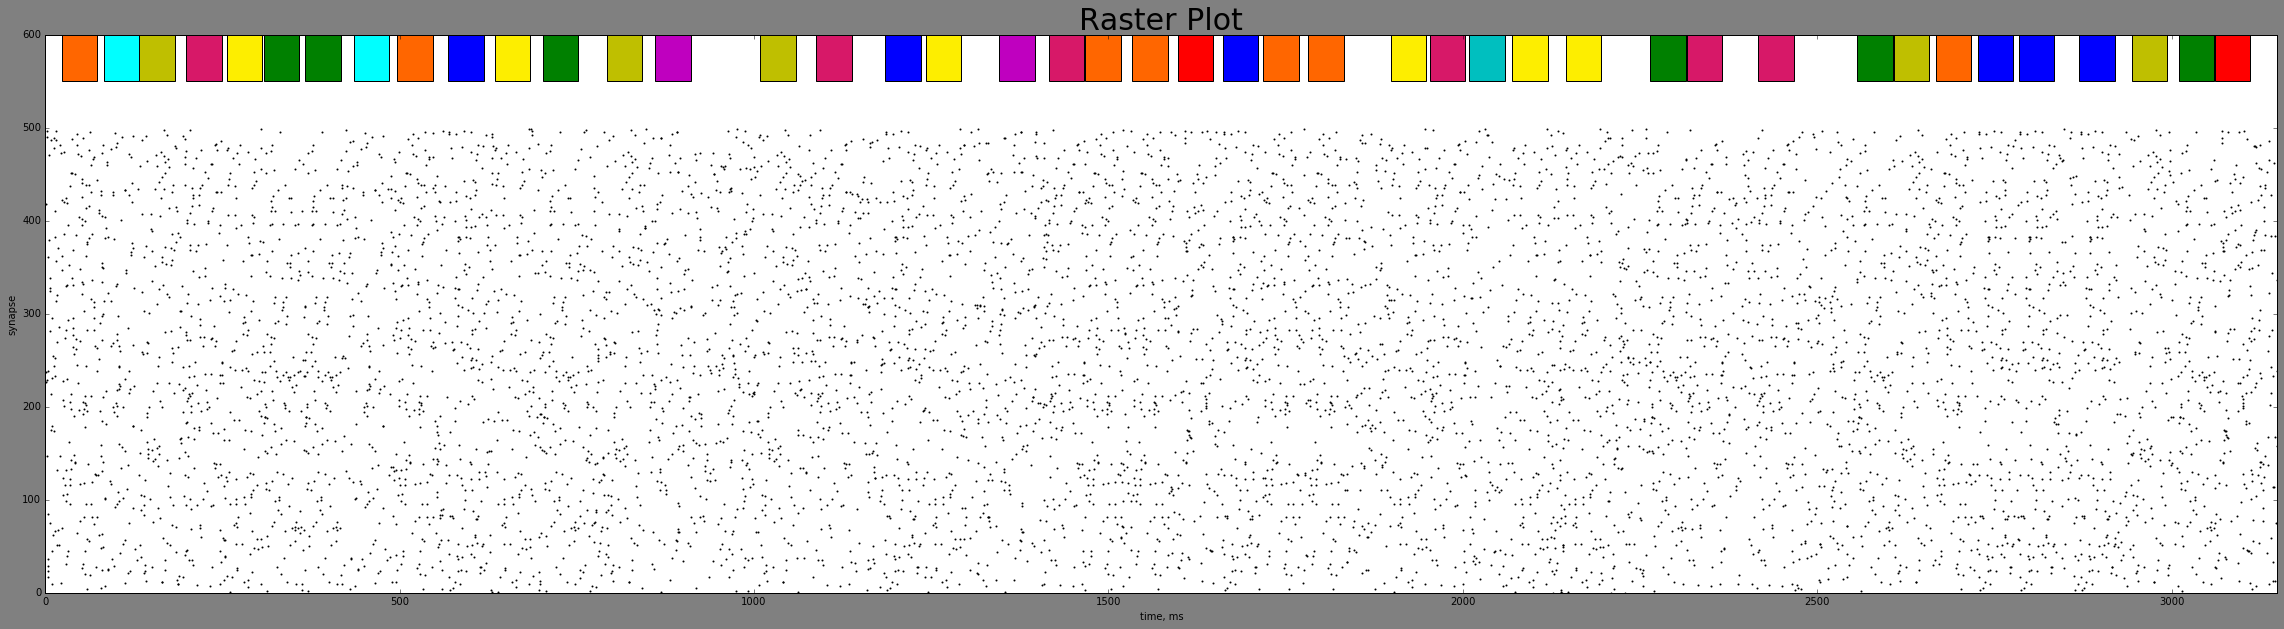

In [5]:
fig,ax=pl.subplots(1,1,figsize=(40,10))
ax.scatter(pattern_df.spk_times, pattern_df.spk_idx, s=1)
ax.set_xlabel('time, ms')
ax.set_ylabel('synapse')
ax.set_title('Raster Plot', fontsize=30)
ax.set_xlim(0,pattern_df.iloc[-1].spk_times)
add_markers(occur_df,ax,num_syn)
ax.set_ylim(0,num_syn*1.2)
occur_df

## 2. Obtain output spike times

Event-based exact solution for given input:

Goal is find output spikes, $\{t^j_{out}\}$, since then an exact solution given weights, $\vec{\omega}$, and input pattern, $\{t^j_i\}$, is just: $$V(t)=V_{rest}+\sum^{N}_{i=1}\omega_i\sum_{t^j_i<t}K(t-t^j_i)-\theta\sum_{t^j_{out}<t}\exp\left(-\frac{t-t^j_{out}}{\tau_m}\right)\;.$$ 

The procedure is event-based, moving from one input spike to the next, each time checking the condition for crossing the spike-threshold. In the event of a crossing, a subsequent machine-exact inversion of the solution to threshold is obtained (for now numerically via a bisection-bracketed Newton's method; alternatively it could be solved analytically for low-integer ratios of $\tau_m/\tau_s$ using polynomial depression-like techniques). A numerically precise and efficient representation of the data for this purpose is $\{D_{m,i}\}_i$ and $\{D_{s,i}\}_i$, where
$$
D_{m,i}= \sum_{t_j\leq t_i}\omega_j\exp(\frac{t_j}{\tau_m})\\
D_{s,i}= \sum_{t_j\leq t_i}\omega_j\exp(\frac{t_j}{\tau_s})
$$
where $i$ and $j$ now index the spike sequence. E.g. the condition for a maximum in the voltage trace after input spike, $t_i$, is $D_{m,i},D_{s,i}>0$. When an outspike, $t_{out}$, is found, $V_{thresh}/V_0\exp(\frac{t_{out}}{\tau_m})$ is subtracted from all $D_{m,i}$, $t_i\geq t_{out}$. Then, the voltage trace for $t\in (t_i,t_{i+1})$ can be written
$$
V(t)=V_0\left(\exp(\log D_{m,i} -t/\tau_m)-\exp(\log D_{s,i} -t/\tau_s)\right)
$$

Define model:

In [6]:
neu_paras=gen_neuron_paras()
weights=np.random.normal(scale=2e-1,size=num_syn) #example

find out-spikes:

In [7]:
precomputed_data=precompute_data_for_iteration(neu_paras,pattern_df,weights)
outspk_times,voltage_at_spikes=get_outspk_times(pattern_df,neu_paras,*precomputed_data,output_voltage=True)

Validate by checking that analytical and numerical solution match:

In [8]:
#numerical solution discretizes input block time window 
def get_pspkernel(time,neu_paras):
    return neu_paras['v_norm']*(np.exp(-time/neu_paras['tau_mem'])-np.exp(-time/neu_paras['tau_syn']))
 
def get_voltagetrace_via_kernelsum(pattern_df,weights,neu_paras,effective_kernel_duration,dt):
    kernel=get_pspkernel(np.arange(0,int(effective_kernel_duration/dt)*dt,dt),neu_paras)   
    time=np.arange(0,int(pattern_df.iloc[-1].spk_times/dt)*dt+(int(effective_kernel_duration/dt)+1)*dt,dt)
    voltage=np.zeros(time.shape)
    for inspk_event in pattern_df.itertuples():
        try:
            voltage[int(inspk_event.spk_times/dt):int(inspk_event.spk_times/dt)+int(effective_kernel_duration/dt)]+=weights[inspk_event.spk_idx]*kernel
        except ValueError:
            voltage[int(inspk_event.spk_times/dt):int(inspk_event.spk_times/dt)+int(effective_kernel_duration/dt)+1]+=weights[inspk_event.spk_idx]*kernel
#             print(int(inspk_event.spk_times/dt))
#             print(int(effective_kernel_duration/dt))
#             print(len(voltage[int(inspk_event.spk_times/dt):int(inspk_event.spk_times/dt)+int(effective_kernel_duration/dt)+1]))
#             print(len(kernel))
    outspk_times=list()
    for time_it, time_inst in enumerate(time[:-1]):
        if voltage[time_it]<neu_paras['v_thresh'] and voltage[time_it+1]>neu_paras['v_thresh']:
            voltage[time_it+1:]-=neu_paras['v_thresh']*np.exp(-(time[time_it+1:]-time_inst)/neu_paras['tau_mem'])
            outspk_times.append(time_inst)
    return time, voltage, outspk_times

In [10]:
dt=0.0001
effective_kernel_duration=int(neu_paras['tau_mem']*10./dt)*dt #time at which remaining kernel mass around 1e-4 of the total 

In [123]:
time, voltage,outspk_times_from_kernel =get_voltagetrace_via_kernelsum(pattern_df,weights,neu_paras,effective_kernel_duration,dt)

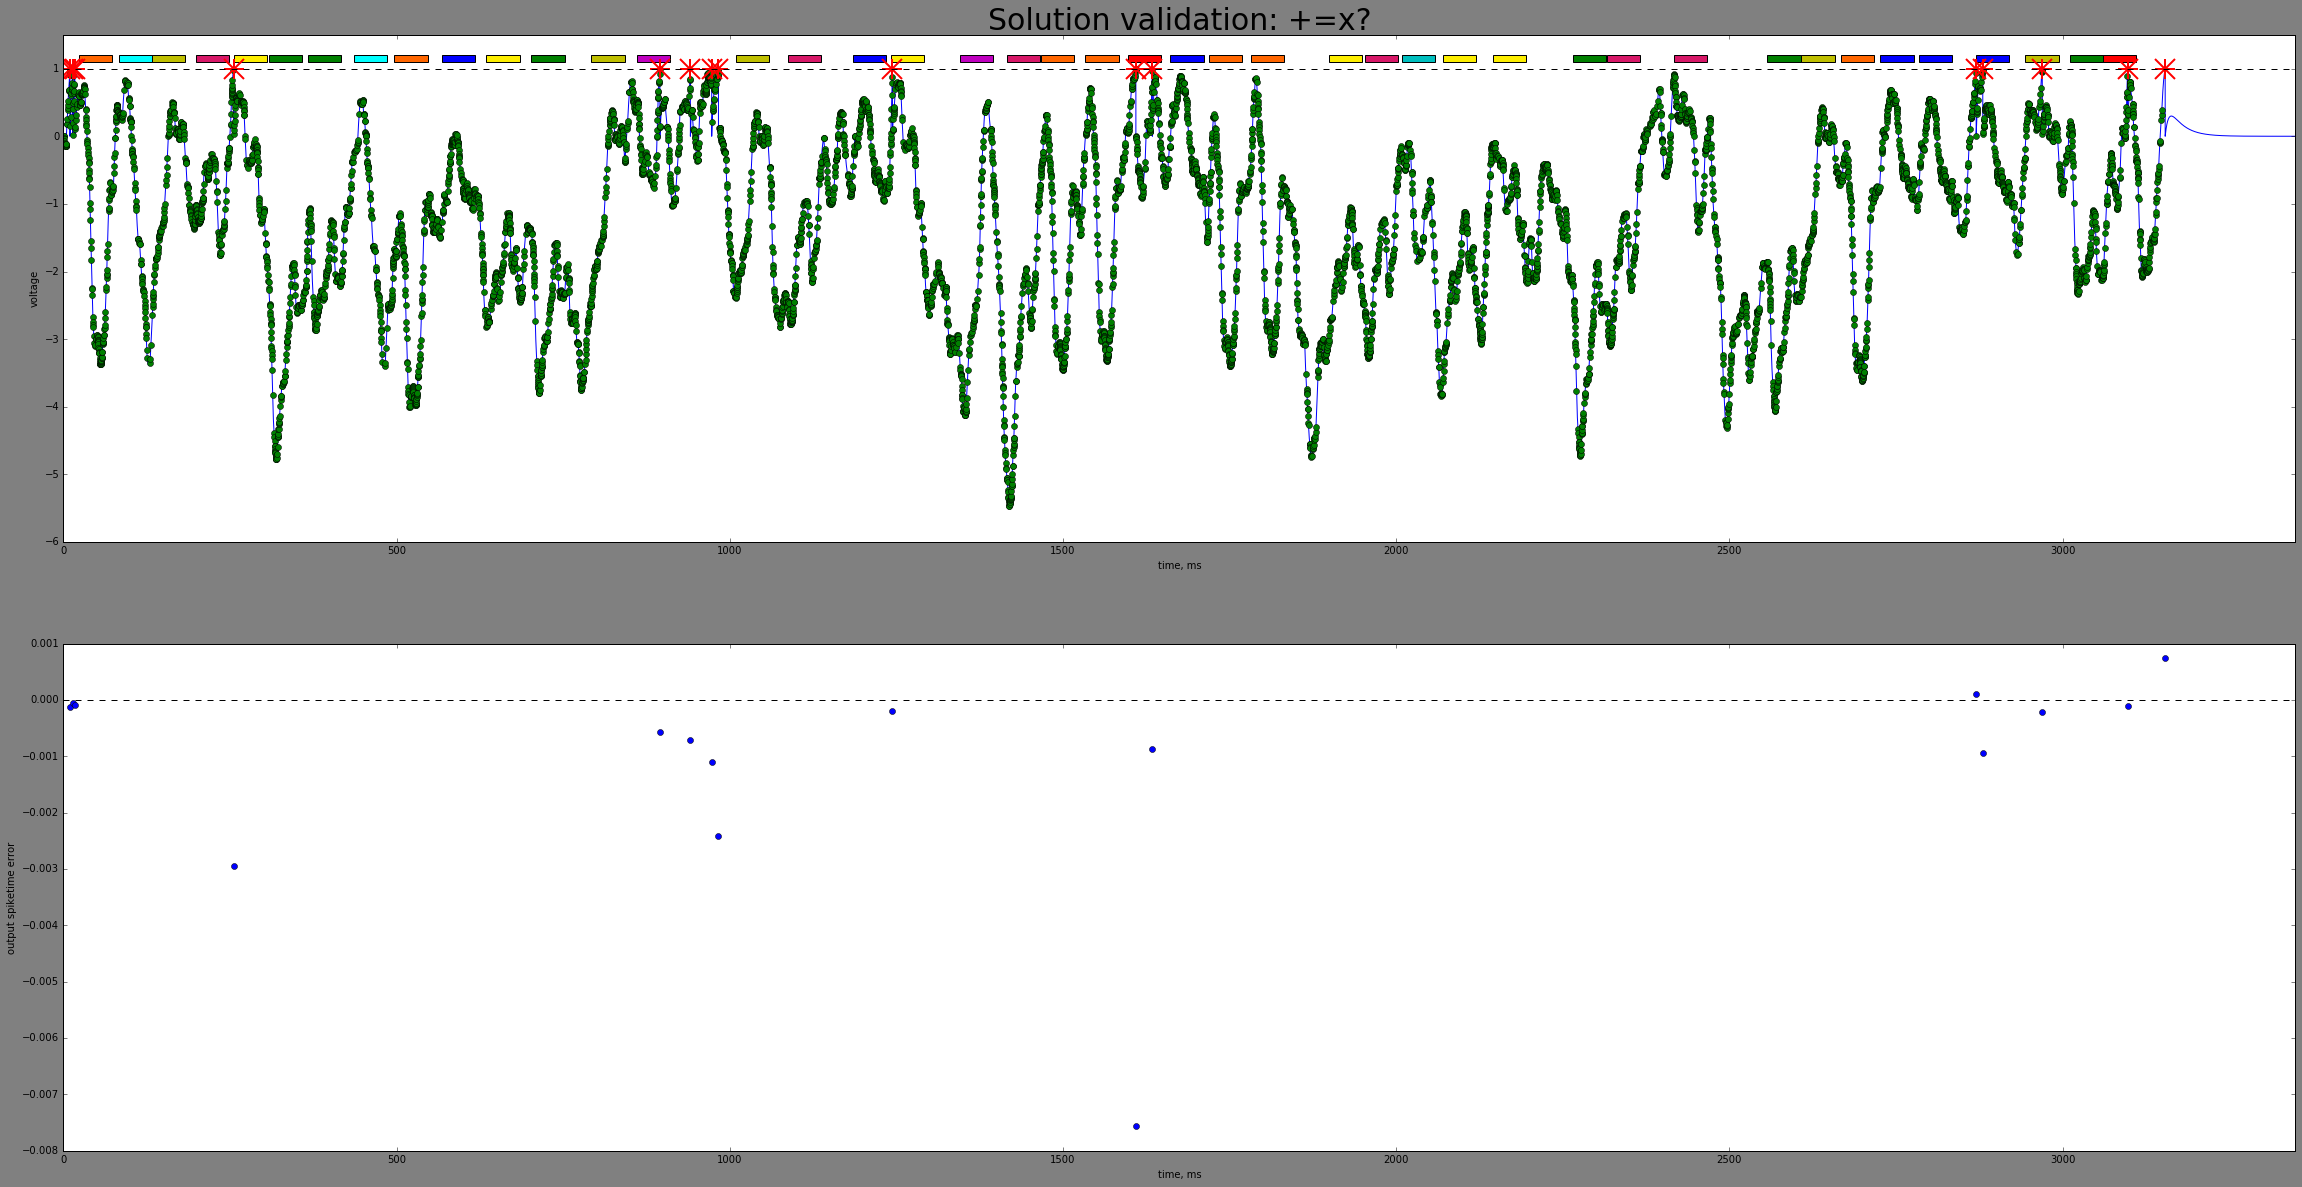

In [124]:
fig,ax=pl.subplots(2,1,figsize=(40,20))
ax[0].plot(time,voltage)
ax[0].plot(pattern_df.iloc[:-1].spk_times.values,voltage_at_spikes,'o')
ax[0].plot(outspk_times_from_kernel,neu_paras['v_thresh']*np.ones(len(outspk_times_from_kernel)),'r+',ms=20, mew=2)
ax[0].plot(outspk_times,neu_paras['v_thresh']*np.ones(len(outspk_times)),'rx',ms=20, mew=2)
ax[0].plot(ax[0].get_xlim(),[neu_paras['v_thresh']]*2,'k--')
ax[0].set_xlabel('time, ms')
ax[0].set_ylabel('voltage')
ax[0].set_xlim(0,time[-1])
ax[0].set_ylim(ax[0].get_ylim()[0],1.5)
ax[0].set_title('Solution validation: +=x?', fontsize=30)
ax[1].plot(outspk_times_from_kernel,outspk_times_from_kernel-outspk_times,'o')
ax[1].plot(ax[0].get_xlim(),[0]*2,'k--')
ax[1].set_xlabel('time, ms')
ax[1].set_ylabel('output spiketime error')
ax[1].set_xlim(0,time[-1])
add_markers(occur_df,ax[0])


(1e-05, 0.1)

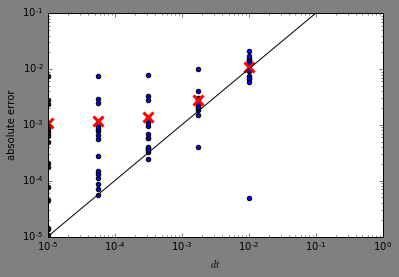

In [11]:
fig,ax=pl.subplots(1,1)
dtvec=np.logspace(-5,-2,5)[::-1]
outspk_store=np.zeros((len(dtvec),100))
for dtit,dt in enumerate(dtvec): #for dt too high the number of spikes can be different
    time, voltage, outspk_times_from_kernel =get_voltagetrace_via_kernelsum(pattern_df,weights,neu_paras,effective_kernel_duration,dt)
    outspk_store[dtit,:len(outspk_times_from_kernel)]=outspk_times_from_kernel
    ax.scatter(dt*np.ones((len(outspk_times_from_kernel),)),np.fabs(outspk_times_from_kernel-outspk_times))
    ax.plot(dt,np.mean(np.fabs(outspk_times_from_kernel-outspk_times)),'rx',ms=10,mew=3)
ax.plot([1e-5,1e-1],[1e-5,1e-1],'k-')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$dt$')
ax.set_ylabel('absolute error')
ax.set_ylim(1e-5,1e-1)

In [110]:
outspk_store[0,:16]

array([    9.98,    14.05,    17.26,   255.46,   895.11,   940.89,
         972.89,   983.02,  1244.12,  1609.36,  1634.13,  2870.2 ,
        2880.13,  2969.43,  3097.41,  3153.83])

In [111]:
outspk_times

array([    9.98652054,    14.05766343,    17.27529407,   255.45995173,
         895.12416878,   940.90441962,   972.90261059,   983.03691354,
        1244.12700567,  1609.38135242,  1634.13586902,  2870.20909607,
        2880.13985065,  2969.43970608,  3097.42370447,  3153.84295583])

(1e-05, 0.1)

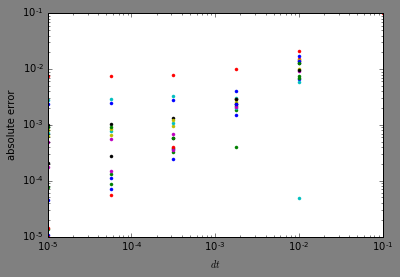

In [119]:
fig,ax=pl.subplots(1,1)
ax.plot(dtvec,np.fabs(outspk_store[:,:len(outspk_times)]-outspk_times[np.newaxis,:]),'.')
ax.plot([1e-5,1e-1],[1e-5,1e-1],'.')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$dt$')
ax.set_ylabel('absolute error')
ax.set_ylim(1e-5,1e-1)

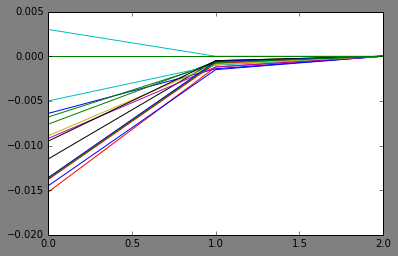

In [76]:
fig,ax=pl.subplots(1,1)
ax.plot(outspk_store-outspk_store[np.newaxis,-1,:])

## Compute the correlation-based eligibilities and update weights

In [15]:
pattern_df['elig']=get_inspk_eligibilities(neu_paras,pattern_df.spk_times.values,outspk_times,*precomputed_data)
elitmp=pattern_df.groupby('spk_idx').elig.sum()
neuron_eligibilities=np.zeros((num_syn,))
neuron_eligibilities[elitmp.index.values]=elitmp.values

Validate using numerical correlation

In [16]:
def kernel_eligibility(row,voltage_trace,effective_kernel_duration,dt):
    return np.dot(voltage_trace[int(row.spk_times/dt):int(row.spk_times/dt)+int(effective_kernel_duration/dt)], get_pspkernel(np.arange(0,int(effective_kernel_duration/dt)*dt,dt),neu_paras)*dt)

In [17]:
dt=0.001
time, voltage,outspk_times_from_kernel =get_voltagetrace_via_kernelsum(pattern_df,weights,neu_paras,effective_kernel_duration,dt)
kernel_eligibility_part=partial(kernel_eligibility,voltage_trace=voltage,effective_kernel_duration=effective_kernel_duration,dt=dt)
pattern_df['elig_ker']=pattern_df.apply(kernel_eligibility_part,axis=1)
elitmp=pattern_df.groupby('spk_idx').elig_ker.sum()
neuron_eligibilities_ker=np.zeros((num_syn,))
neuron_eligibilities_ker[elitmp.index.values]=elitmp.values

ker match for :30


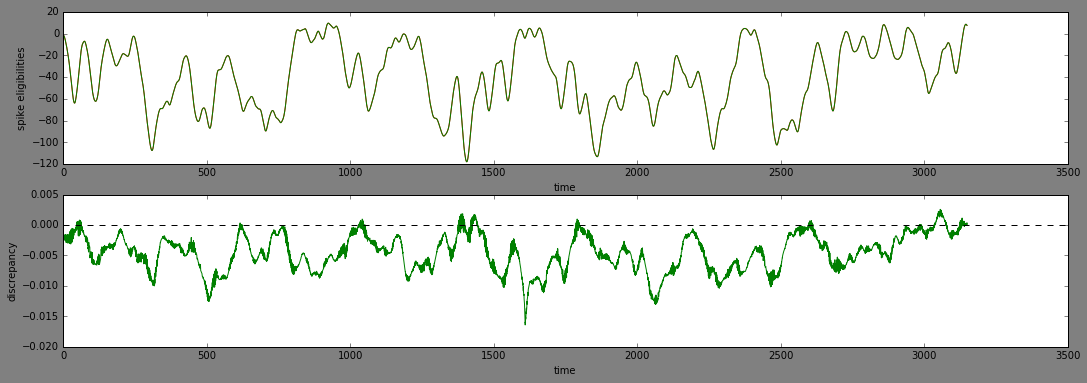

In [18]:
fig,ax=pl.subplots(2,1,figsize=(18,6))
ax[0].plot(pattern_df.spk_times,pattern_df['elig_ker'],'r')
ax[0].plot(pattern_df.spk_times,pattern_df['elig'],'g')    
ax[0].set_ylabel('spike eligibilities')
ax[0].set_xlabel('time')
ax[1].plot(pattern_df.spk_times,pattern_df['elig']-pattern_df['elig_ker'],'g')
ax[1].plot(ax[0].get_xlim(),[0]*2,'k--')
ax[1].set_ylabel('discrepancy')
ax[1].set_xlabel('time')
print('ker match for :'+str(len(np.intersect1d(np.argsort(neuron_eligibilities_ker)[:30], np.argsort(neuron_eligibilities)[:30]))))

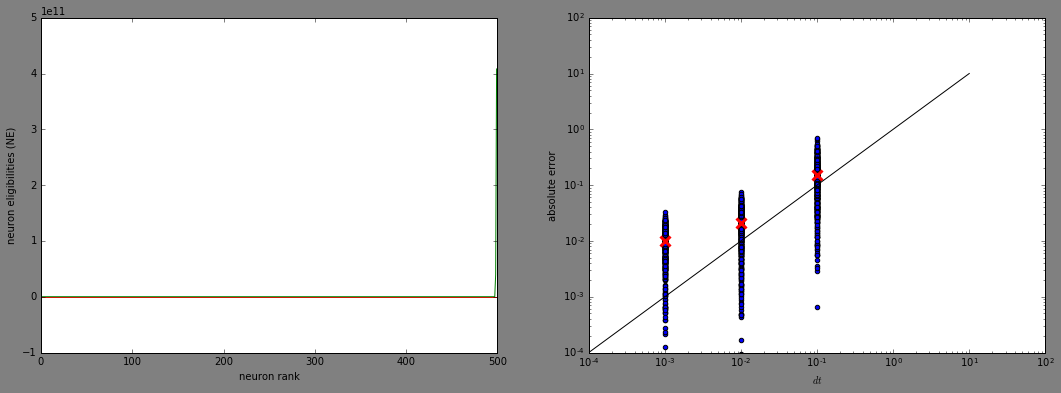

In [34]:
fig,ax=pl.subplots(1,2,figsize=(18,6))
for dt in np.logspace(-3,-1,3)[::-1]:
    time, voltage,outspk_times_from_kernel =get_voltagetrace_via_kernelsum(pattern_df,weights,neu_paras,effective_kernel_duration,dt)
    kernel_eligibility_part=partial(kernel_eligibility,voltage_trace=voltage,effective_kernel_duration=effective_kernel_duration,dt=dt)
    
    pattern_df['elig_ker']=pattern_df.apply(kernel_eligibility_part,axis=1)
    elitmp=pattern_df.groupby('spk_idx').elig_ker.sum()
    neuron_eligibilities_ker=np.zeros((num_syn,))
    neuron_eligibilities_ker[elitmp.index.values]=elitmp.values
    
    ax[0].plot(np.sort(neuron_eligibilities_ker),'r')
    ax[1].scatter(dt*np.ones((num_syn,)),np.fabs(neuron_eligibilities_ker-neuron_eligibilities))
    ax[1].plot(dt,np.mean(np.fabs(neuron_eligibilities_ker-neuron_eligibilities)),'rx',ms=10,mew=3)

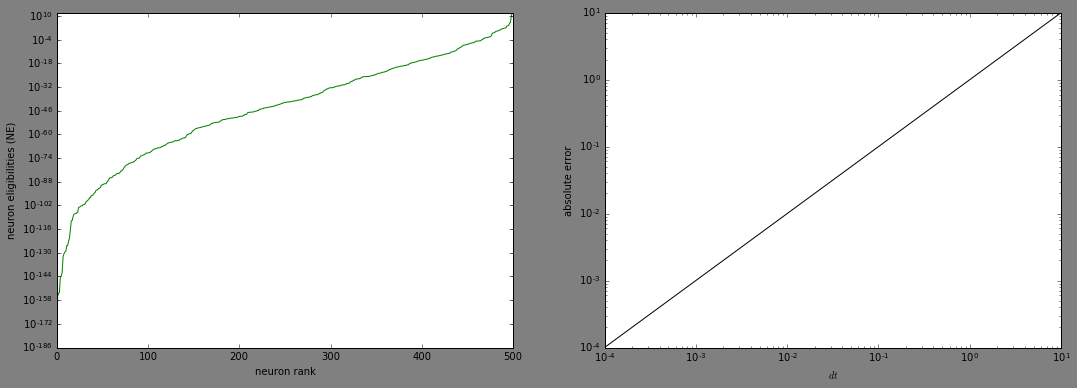

In [37]:
fig,ax=pl.subplots(1,2,figsize=(18,6))
ax[0].plot(np.exp(np.sort(neuron_eligibilities)),'g')
ax[0].set_ylabel('neuron eligibilities (NE)')
ax[0].set_xlabel('neuron rank')
ax[1].plot([1e-4,1e1],[1e-4,1e1],'k-')
ax[1].set_xlabel(r'$dt$')
ax[1].set_ylabel('absolute NE error')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_ylabel('absolute error')

sometimes see imprecision here depending on the realization...the largest neuron eleigiibities seem unaffected:

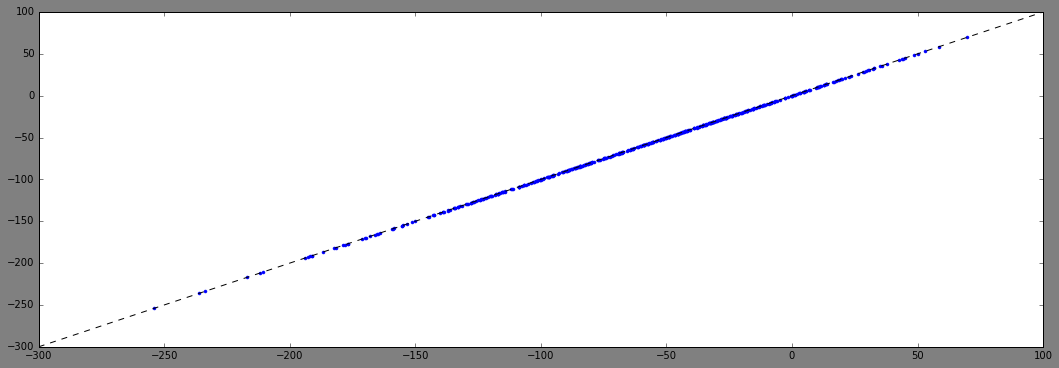

In [31]:
fig,ax=pl.subplots(1,1,figsize=(18,6))
ax.plot(neuron_eligibilities,neuron_eligibilities_ker,'.')
ax.plot(ax.get_xlim(),ax.get_xlim(),'k--')

Run learning by running the tempytron_main.py script

Read in saved output data from learning:

In [13]:
def plot_stuff(batchname,step_size):
    cur_weights_list=list(np.load(batchname+'cur_weights_list.npy'))
    out_rates=np.load(batchname+'excess_rates_stepsize_'+str(step_size)+'.npy')
    bkgd_rates=np.load(batchname+'bkgd_rates_stepsize_'+str(step_size)+'.npy')
    print(len(out_rates))
    itervec=1+np.arange(len(out_rates))*step_size
    legend = ['Clue 1', 'Distractor 1', 'Distractor 2', 'Distractor 3', 'Distractor 4']
    legend = ['Clue 1', 'Clue 2', 'Clue 3', 'Clue 4', 'Clue 5', 'Distractor 1','Distractor 2','Distractor 3','Distractor 4','Distractor 5']
    legend = ['Clue 1']
    legend = ['Clue 1','Distractor 1','Distractor 2','Distractor 3','Distractor 4','Distractor 5','Distractor 6','Distractor 7','Distractor 8','Distractor 9']

    fig,ax1=pl.subplots(1,1)
    for rit,row in enumerate(out_rates.T):
        ax1.plot(itervec,row,'.-',label=legend[rit])
    ax1.set_xlabel('Cycles')
    ax1.set_ylabel('Spikes')
    ax1.set_ylim(0,6)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Rate (Hz)')
    ax2.plot(itervec,bkgd_rates[:,0],'k.-',label='Background Activity')
    ax1.legend(bbox_to_anchor=(1.1, 1), loc='upper left', ncol=1)
    pl.legend(bbox_to_anchor=(1.625, 0.1))
    fig.savefig(batchname+'_learningcurves'+'.pdf',format= 'pdf',dpi=1000, bbox_inches='tight')
    fig,ax=pl.subplots(1,1)
    for row in np.array(cur_weights_list).T:
        ax.plot(row)

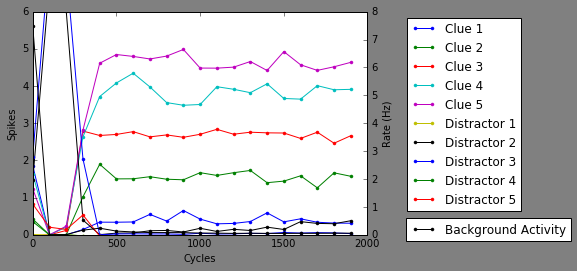

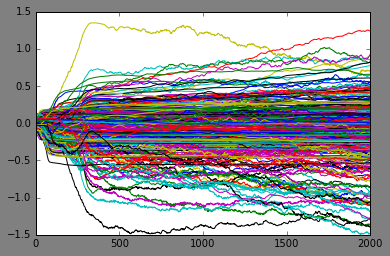

In [79]:
plot_stuff('data/v1_momentum_labels_1_2_3_4_5_0_0_0_0_0_',100)

20


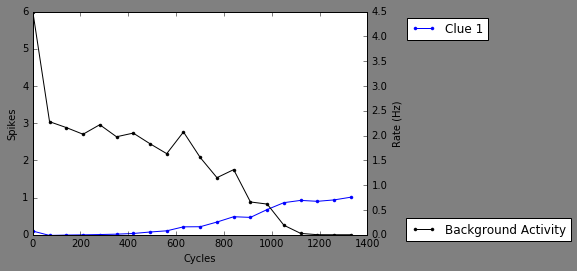

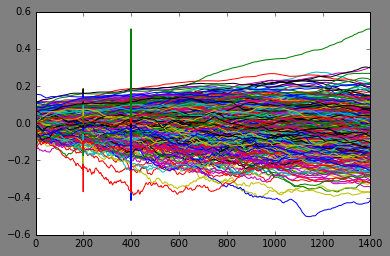

In [16]:
plot_stuff('data/v1_momentum_labels_1_',70)

20


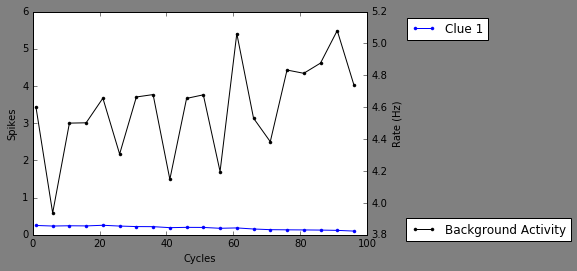

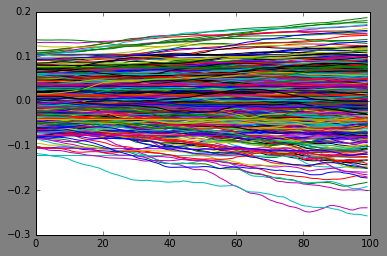

In [18]:
plot_stuff('data/v2_momentum_cf_5_labels_1_',5)

20


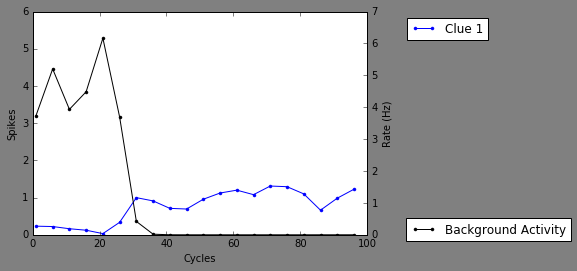

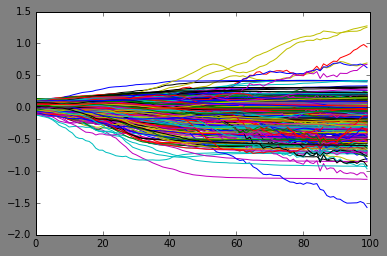

In [38]:
plot_stuff('data/v2_momentum_cf_5_lr_4_labels_1_',5)

20


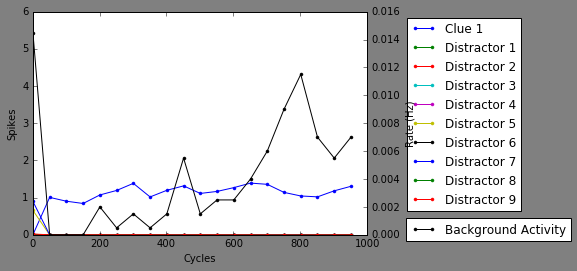

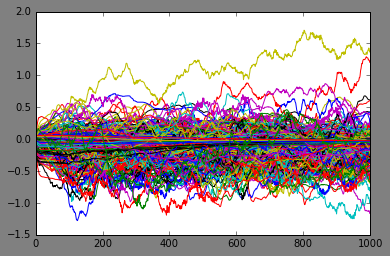

In [50]:
plot_stuff('data/v2_momentum_cf_2_lr_4_norm_labels_1_0_0_0_0_0_0_0_0_0_',50)

20


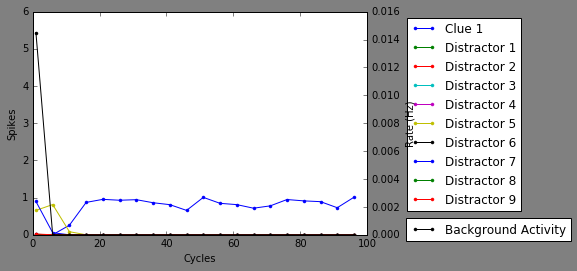

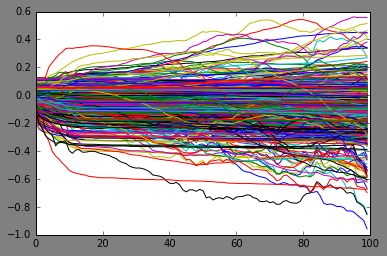

In [14]:
plot_stuff('data/v2_momentum_fix_cf_2_lr_4_norm_labels_1_0_0_0_0_0_0_0_0_0_',5)